In [24]:
import pandas as pd
import numpy as np
import plotly.express as px
df = pd.read_csv('data.csv')
print(df.columns)

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')


In [25]:
%load_ext tensorboard
import datetime
import tensorflow as tf
from tensorflow.keras import layers
log_dir = "log/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [26]:
filtered_df = df.copy()
filtered_df['artists'] = filtered_df['artists'].apply(lambda x: x[1:-1].replace("'", ""))
art = filtered_df['artists'].sample()
print(len(art))
print(art.values[0])#.index[0]

1
Lil Tjay


In [27]:
filtered_df = filtered_df.drop(columns=['id']) #we dont need the spotify id's 
# remastered_list = [x for x in filtered_df.name if "remaster" in x.lower()]
# len(remastered_list)
# filtered_df = filtered_df[~filtered_df.name.isin(remastered_list)] # all the songs without the remastered 

# #are there any songs with the named remaster im discriminating against?
# #should i just get rid of everything remastered?

# skits_list = [x for x in filtered_df.name if "skit" in x.lower()]
# filtered_df = filtered_df[~filtered_df.name.isin(skits_list)]
# #28 skits a few are actual songs but idt they will be impactful

# demo_list = [x for x in filtered_df.name if "demo " in x.lower()]
# filtered_df = filtered_df[~filtered_df.name.isin(demo_list)]

In [28]:
filenames = ['classical_idx.csv','hip-hop_idx.csv','jazz_idx.csv','metal_idx.csv','reggae_idx.csv','rock_idx.csv']

gen = pd.DataFrame(0, index=np.arange(filtered_df.shape[0]),columns=['genera'])

#filtered_data['genera'] = 
for n in filenames:
    gen.iloc[pd.read_csv('genera_csv/'+n, header=None).iloc[:,0]] = n[:-8]

In [29]:
final_df = filtered_df.join(gen)
labeled_data = final_df[final_df.genera != 0]
unlabeled_data = final_df[final_df.genera == 0]

In [30]:
y = labeled_data.genera
features_list = ['valence', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']
X = labeled_data.copy()#[features_list].copy()
Z = unlabeled_data.copy()#[features_list].copy()

In [31]:
from sklearn.preprocessing import MinMaxScaler
to_norm_list = ['duration_ms', 'key','loudness', 'popularity', 'tempo']

scaler = MinMaxScaler(feature_range=(0, 1))
d = scaler.fit_transform(X[to_norm_list])
scaled_df = pd.DataFrame(d, columns=to_norm_list)
scaled_df.head()
X.drop(to_norm_list, axis=1,inplace=True)
X = X.reset_index(drop=True)
X[to_norm_list] = scaled_df
y



137       classical
229            jazz
806            jazz
814            jazz
1409           jazz
            ...    
167324       reggae
167516       reggae
168592         rock
169414         jazz
169454    classical
Name: genera, Length: 606, dtype: object

In [32]:
y.sample(20)

11150        reggae
35007          rock
48913         metal
8912           rock
28557        reggae
11236          rock
7263           jazz
10857          rock
86024     classical
11007          rock
14025         metal
147541       reggae
11640        reggae
16446       hip-hop
30073        reggae
9620           rock
12239         metal
7059           jazz
31341          rock
10412          rock
Name: genera, dtype: object

In [33]:
y = pd.get_dummies(y)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[features_list], y,test_size=0.2)


In [35]:


model = tf.keras.Sequential()
model.add(layers.Dense(units=6, input_shape=(len(features_list),)))
model.add(layers.Dense(units=6))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', 'mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 42        
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=20, callbacks=[tensorboard_callback])

Train on 484 samples, validate on 122 samples
Epoch 1/20
484/484 [==============================] - 0s 277us/sample - loss: 8.7594 - categorical_accuracy: 0.3388 - mean_squared_error: 0.3241 - val_loss: 8.6719 - val_categorical_accuracy: 0.3033 - val_mean_squared_error: 0.3518
Epoch 2/20
484/484 [==============================] - 0s 68us/sample - loss: 7.6404 - categorical_accuracy: 0.2645 - mean_squared_error: 0.3666 - val_loss: 7.8000 - val_categorical_accuracy: 0.2623 - val_mean_squared_error: 0.3763
Epoch 3/20
484/484 [==============================] - 0s 67us/sample - loss: 7.0400 - categorical_accuracy: 0.2066 - mean_squared_error: 0.3855 - val_loss: 7.3975 - val_categorical_accuracy: 0.1967 - val_mean_squared_error: 0.3856
Epoch 4/20
484/484 [==============================] - 0s 66us/sample - loss: 6.4945 - categorical_accuracy: 0.1405 - mean_squared_error: 0.4122 - val_loss: 6.3328 - val_categorical_accuracy: 0.1557 - val_mean_squared_error: 0.4201
Epoch 5/20
484/484 [=========

Minimum Validation Loss: 3.6635


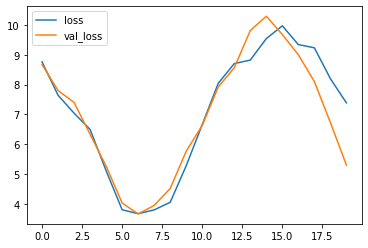

In [37]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

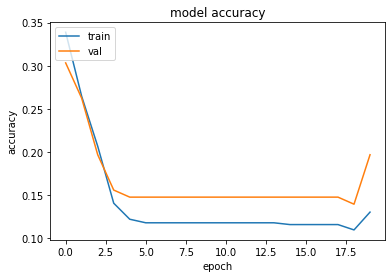

In [38]:
from matplotlib import pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
history.history

{'loss': [8.759443815089455,
  7.640370644813727,
  7.0399527589151685,
  6.49446288022128,
  5.112241244513141,
  3.8030540440693374,
  3.6715308329290597,
  3.7982399128069564,
  4.05312332240018,
  5.279471686186869,
  6.658752989177861,
  8.040614963563021,
  8.7022444157561,
  8.820300914039297,
  9.540230636754313,
  9.968247921998836,
  9.339215475665636,
  9.23168290351048,
  8.197217665427972,
  7.3854208623082185],
 'categorical_accuracy': [0.338843,
  0.2644628,
  0.20661157,
  0.14049587,
  0.12190083,
  0.11776859,
  0.11776859,
  0.11776859,
  0.11776859,
  0.11776859,
  0.11776859,
  0.11776859,
  0.11776859,
  0.11776859,
  0.11570248,
  0.11570248,
  0.11570248,
  0.11570248,
  0.10950413,
  0.1301653],
 'mean_squared_error': [0.32407504,
  0.36659437,
  0.38546813,
  0.41224784,
  0.46472752,
  0.5358628,
  0.54341644,
  0.53994745,
  0.5438594,
  0.5466193,
  0.5448204,
  0.5385784,
  0.5311389,
  0.5311408,
  0.5081027,
  0.4795015,
  0.47204462,
  0.42543474,
  0.3